In [1]:
# FinRL-Based Daily ETF Agent (Local Version)
# Author: Wilson & ChatGPT
# Goal: Use FinRL library to forecast daily ETF trading on QQQ/PSQ using PPO

# === Cell 1: SETUP & GENERAL IMPORTS ===
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Set root directory for saving results (outside 'agent')
ROOT_DIR = "../finrl_outputs"
os.makedirs(ROOT_DIR, exist_ok=True)

# === [next cell will handle FinRL module imports] ===

In [2]:
import warnings
warnings.filterwarnings("ignore")
# === Cell 2: FINRL MODULE IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools



In [ ]:
# === Custom Output Paths (adjusted for your folder layout) ===
import os
from finrl import config

# Redirect FinRL output dirs
config.DATA_SAVE_DIR = "../finrl_outputs/data"
config.TRAINED_MODEL_DIR = "../finrl_outputs/trained_models"
config.TENSORBOARD_LOG_DIR = "../finrl_outputs/tensorboard_logs"
config.RESULTS_DIR = "../finrl_outputs/results"

# Make sure all paths exist
os.makedirs(config.DATA_SAVE_DIR, exist_ok=True)
os.makedirs(config.TRAINED_MODEL_DIR, exist_ok=True)
os.makedirs(config.TENSORBOARD_LOG_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)



In [4]:
from datetime import datetime, timedelta

# === Cell X: DATA DOWNLOAD WITH AUTO-DATE RANGES ===

from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

# Custom ETF list
tickers = ["QQQ", "SPY"]

# Dynamically calculate dates
today = datetime.today()
TRAIN_START_DATE = (today.replace(year=today.year - 20)).strftime("%Y-%m-%d")  # 20 years ago
TRAIN_END_DATE = (today.replace(year=today.year - 3)).strftime("%Y-%m-%d")     # 3 years ago
TEST_START_DATE = TRAIN_END_DATE
TEST_END_DATE = today.strftime("%Y-%m-%d")

# Download historical data
data_processor = YahooFinanceProcessor()
df_raw = data_processor.download_data(
    start_date=TRAIN_START_DATE,
    end_date=TEST_END_DATE,
    ticker_list=tickers,
    time_interval="1d"
)

df_raw.head()


YF.download() has changed argument auto_adjust default to True
YF deprecation warning: set proxy via new config function: yf.set_proxy(proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QQQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-04-30 00:00:00 -> 2005-05-01 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QQQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-05-01 00:00:00 -> 2005-05-02 00:00:00)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**

,timestamp,close,high,low,open,volume,tic
0,2005-04-27,30.049006,30.177421,29.732251,29.852104,112539300.0,QQQ
1,2005-04-28,29.749380,30.091820,29.723698,29.894915,98181900.0,QQQ
2,2005-04-29,29.946287,30.014777,29.406945,29.963409,144435900.0,QQQ
3,2005-05-02,30.066149,30.186002,29.869247,30.049026,67648800.0,QQQ
4,2005-05-03,30.220238,30.331531,29.989091,30.006213,103428700.0,QQQ


In [10]:
print("Before feature engineering:")
print("  Total rows:", len(df_raw))
print("  Unique dates:", df_raw['date'].nunique())
print("  Unique tic-date pairs:", df_raw[['date', 'tic']].drop_duplicates().shape[0])
print("  Duplicated date-tic rows:", df_raw.duplicated(subset=['date', 'tic']).sum())


Before feature engineering:
  Total rows: 10066
  Unique dates: 5032
  Unique tic-date pairs: 10064
  Duplicated date-tic rows: 2


In [15]:

# === Cell X: FEATURE ENGINEERING (CLEANED AND FIXED) ===

from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# === Clean up and normalize column names for stockstats ===
df_raw = df_raw.rename(columns={"timestamp": "date"})
df_raw.columns = [col.lower() for col in df_raw.columns]
df_raw["date"] = pd.to_datetime(df_raw["date"]).dt.strftime("%Y-%m-%d")

# 🧼 Drop duplicate (date, tic) rows to avoid merge/index mismatch
df_raw = df_raw.drop_duplicates(subset=["date", "tic"])

# === Define technical indicators to use ===
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']

# === Initialize FeatureEngineer ===
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_turbulence=True,
    user_defined_feature=False
)

# === Apply feature engineering ===
processed = fe.preprocess_data(df_raw)
processed = processed.fillna(0).replace(np.inf, 0)

# === Preview output ===
print("Processed data shape:", processed.shape)
print("Columns:", processed.columns.tolist())
processed.head(30)


Successfully added technical indicators
Successfully added turbulence index
Processed data shape: (10064, 12)
Columns: ['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']


,date,close,high,low,open,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2005-04-27,30.049006,30.177421,29.732251,29.852104,112539300.0,QQQ,0.000000,0.000000,-66.666667,100.000000,0.0
1,2005-04-27,79.445679,79.734196,78.614471,78.902988,84131900.0,SPY,0.000000,0.000000,-66.666667,100.000000,0.0
2,2005-04-28,29.749380,30.091820,29.723698,29.894915,98181900.0,QQQ,-0.006722,0.000000,-66.666667,100.000000,0.0
3,2005-04-28,78.449654,79.466341,78.449654,79.184690,72481500.0,SPY,-0.022347,0.000000,-66.666667,100.000000,0.0
4,2005-04-29,29.946287,30.014777,29.406945,29.963409,144435900.0,QQQ,-0.002460,40.470475,-80.000095,100.000000,0.0
5,2005-04-29,79.514374,79.596810,78.291605,79.047248,103993800.0,SPY,0.004543,52.512791,26.181068,100.000000,0.0
6,2005-05-02,30.066149,30.186002,29.869247,30.049026,67648800.0,QQQ,0.003867,52.560351,85.579331,27.909258,0.0
7,2005-05-02,79.960930,79.967801,79.356411,79.734235,56026400.0,SPY,0.032784,61.324577,126.699825,11.899453,0.0
8,2005-05-03,30.220238,30.331531,29.989091,30.006213,103428700.0,QQQ,0.013355,62.648514,118.176661,3.645660,0.0
9,2005-05-03,80.098312,80.270050,79.473191,79.734230,86000300.0,SPY,0.052906,63.481239,99.597520,40.763273,0.0


In [13]:
# === Cell X: ENVIRONMENT CONFIGURATION ===

# Count how many unique stocks we have
stock_dimension = len(processed.tic.unique())

# Compute state space size
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# Main env config (used in the pipeline)
env_kwargs = {
    "hmax": 100,
    "initial_amount": 2000,  # 🧠 You set this earlier
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 5,
}

# === Optional: Manual version with individual costs or share counts ===
# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 2000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }


Stock Dimension: 2, State Space: 13


In [17]:
# === Cell X: DRL ENSEMBLE AGENT SETUP ===



# Rebalance and validation windows (e.g. 63 days ~ 3 months of trading)
rebalance_window = 63
validation_window = 63

# Instantiate ensemble agent
ensemble_agent = DRLEnsembleAgent(
    df=processed,
    train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
    val_test_period=(TEST_START_DATE, TEST_END_DATE),
    rebalance_window=rebalance_window,
    validation_window=validation_window,
    **env_kwargs
)

# === Optional: Use single DRL model directly ===
# from finrl.agents.stablebaselines3.models import DRLAgent
# from finrl.env.env_stock_trading import StockTradingEnv
#
# e_train_gym = StockTradingEnv(df=processed, **env_kwargs)
# agent = DRLAgent(e_train_gym)
# model_a2c = agent.get_model("a2c")
# trained_a2c = agent.train_model(
#     model=model_a2c,
#     tb_log_name='a2c',
#     total_timesteps=50000
# )


In [18]:
# === Cell X: MODEL CONFIGURATION ===

# A2C hyperparameters
A2C_model_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0.0007
}

# PPO hyperparameters
PPO_model_kwargs = {
    "ent_coef": 0.01,
    "n_steps": 2048,
    "learning_rate": 0.00025,
    "batch_size": 128
}

# DDPG hyperparameters
DDPG_model_kwargs = {
    "buffer_size": 10_000,
    "learning_rate": 0.0005,
    "batch_size": 64
}

# SAC hyperparameters
SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

# TD3 hyperparameters
TD3_model_kwargs = {
    "batch_size": 100,
    "buffer_size": 1000000,
    "learning_rate": 0.0001
}

# Total training timesteps for each model
timesteps_dict = {
    'a2c': 10_000,
    'ppo': 10_000,
    'ddpg': 10_000,
    'sac': 10_000,
    'td3': 10_000
}


In [23]:
# === Cell X: RUN ENSEMBLE STRATEGY ===

df_summary = ensemble_agent.run_ensemble_strategy(
    A2C_model_kwargs,
    PPO_model_kwargs,
    DDPG_model_kwargs,
    SAC_model_kwargs,
    TD3_model_kwargs,
    timesteps_dict
)


============Start Ensemble Strategy============
turbulence_threshold:  20.564223074924595
======Model training from:  2005-04-27 to  2022-04-28
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to ../finrl_outputs/tensorboard_logs/a2c\a2c_126_2
------------------------------------------
| time/                 |                |
|    fps                | 286            |
|    iterations         | 100            |
|    time_elapsed       | 1              |
|    total_timesteps    | 500            |
| train/                |                |
|    entropy_loss       | -2.87          |
|    explained_variance | -1.54e+04      |
|    learning_rate      | 0.0007         |
|    n_updates          | 99             |
|    policy_loss        | -0.464         |
|    reward             | -0.00016466224 |
|    std                | 1.01           |
|    value_loss         | 0.0265         |
------------------------------------------
-----

In [24]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2022-04-28,2022-07-29,DDPG,-0.095179,-0.268582,0.0,-0.077449,-0.033395
1,189,2022-07-29,2022-10-27,DDPG,-0.279757,-0.267499,-0.13897,-0.176312,-0.13897
2,252,2022-10-27,2023-01-30,SAC,0.16972,0.124704,0.164164,0.28474,0.0
3,315,2023-01-30,2023-05-01,PPO,0.074438,0.206939,0.1419,0.191064,0.1419
4,378,2023-05-01,2023-08-01,DDPG,0.511703,0.136327,0.565514,0.381936,0.480617
5,441,2023-08-01,2023-10-30,DDPG,-0.421838,-0.454611,0.0,-0.514285,-0.421838
6,504,2023-10-30,2024-01-31,TD3,0.836238,0.352219,0.0,0.614983,0.859178
7,567,2024-01-31,2024-05-01,SAC,-0.079719,0.058663,0.181643,0.206038,0.181643
8,630,2024-05-01,2024-08-01,TD3,0.093489,0.024915,0.340901,0.396477,0.478563
9,693,2024-08-01,2024-10-30,SAC,-0.113325,-0.111491,0.203791,0.288543,0.0


[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_126.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_189.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_252.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_315.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_378.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_441.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_504.csv with columns: ['account_value', 'date', 'daily_return']
[✓] Loaded ../finrl_outputs\results\account_value_trade_ensemble_567.csv with columns: ['account_

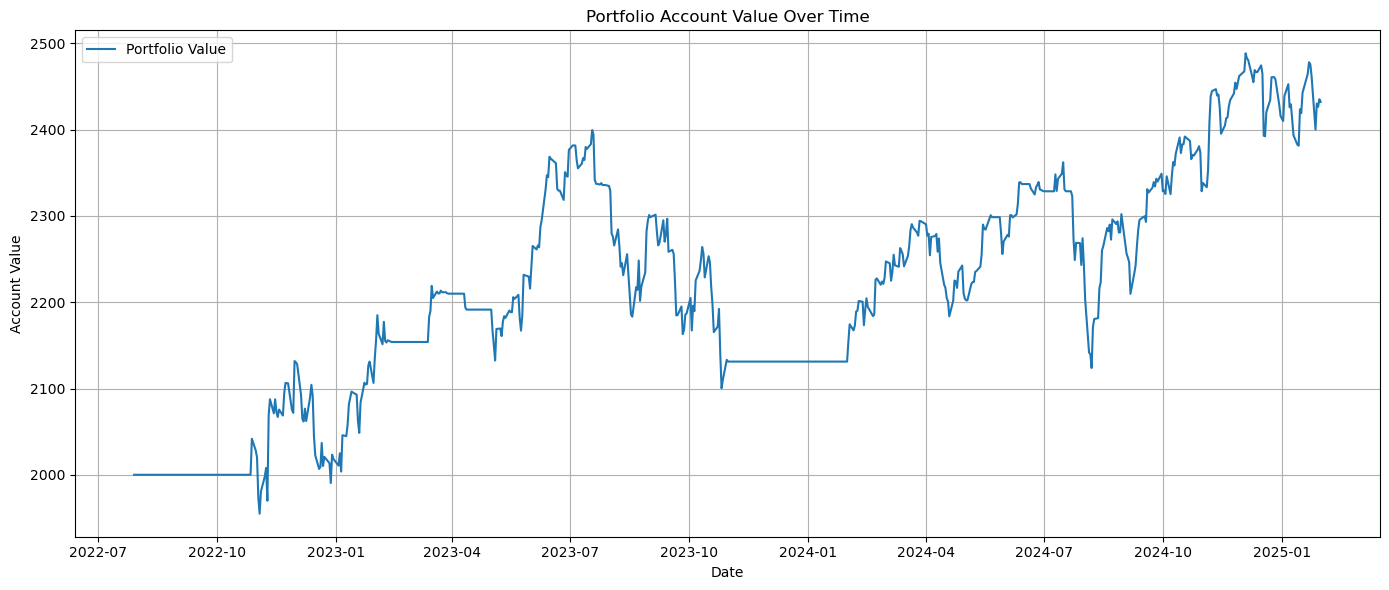

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Collect account value logs
df_account_value = pd.DataFrame()
for i in range(rebalance_window + validation_window, len(processed.date.unique()) + 1, rebalance_window):
    path = os.path.join(RESULTS_DIR, f"account_value_trade_ensemble_{i}.csv")
    if os.path.exists(path):
        temp = pd.read_csv(path)
        print(f"[✓] Loaded {path} with columns: {temp.columns.tolist()}")
        df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
    else:
        print(f"[!] File not found: {path}")

# Confirm expected column exists
if "account_value" not in df_account_value.columns:
    raise ValueError(f"[X] Column 'account_value' not found. Available columns: {df_account_value.columns.tolist()}")

# Compute Sharpe Ratio
returns = df_account_value["account_value"].pct_change(1)
sharpe = (252**0.5) * returns.mean() / returns.std()
print(f"Sharpe Ratio: {sharpe:.4f}")

# Plot
df_account_value["date"] = pd.to_datetime(df_account_value["date"])
plt.figure(figsize=(14,6))
plt.plot(df_account_value["date"], df_account_value["account_value"], label="Portfolio Value")
plt.title("Portfolio Account Value Over Time")
plt.xlabel("Date")
plt.ylabel("Account Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# backtest status

In [30]:
# === Part X: BACKTEST METRICS & BASELINE COMPARISON ===

from finrl.plot import backtest_stats, get_baseline
from datetime import datetime
import os

# Save timestamped summary
now = datetime.now().strftime('%Y%m%d-%Hh%M')

# Compute performance statistics of our portfolio
print("============== Get Backtest Results ==============")
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv(f"finrl_outputs/summary_perf_{now}.csv")

# === Get baseline index stats (Dow Jones Index) ===
print("============== Get Baseline Stats ==============")
df_dji_raw = get_baseline(
    ticker="^DJI",
    start=df_account_value.loc[0, 'date'],
    end=df_account_value.loc[len(df_account_value)-1, 'date']
)

# Normalize baseline to same starting amount
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_raw['close'] / df_dji_raw['close'].iloc[0] * env_kwargs["initial_amount"]

# Save both outputs
df_account_value.to_csv("finrl_outputs/df_account_value.csv", index=False)
df_dji.to_csv("finrl_outputs/df_dji.csv", index=False)

# Also return DataFrame for reuse
df_dji = df_dji.set_index('date')
df_account_value = df_account_value.set_index('date')

print("Saved: df_account_value.csv, df_dji.csv, and perf_stats CSV.")


============== Get Backtest Results ==============
Annual return          0.081429
Cumulative returns     0.216173
Annual volatility      0.121156
Sharpe ratio           0.707687
Calmar ratio           0.652951
Stability              0.652891
Max drawdown          -0.124710
Omega ratio            1.155867
Sortino ratio          1.034584
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.039027
Daily value at risk   -0.014924
dtype: float64


OSError: Cannot save file into a non-existent directory: 'finrl_outputs'

# backtestPlot

Saved ensemble results to: ../finrl_outputs\results\df_result_ensemble.csv


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (629, 8)
Saved result comparison to: ../finrl_outputs\results\result_ensemble_vs_spy.csv


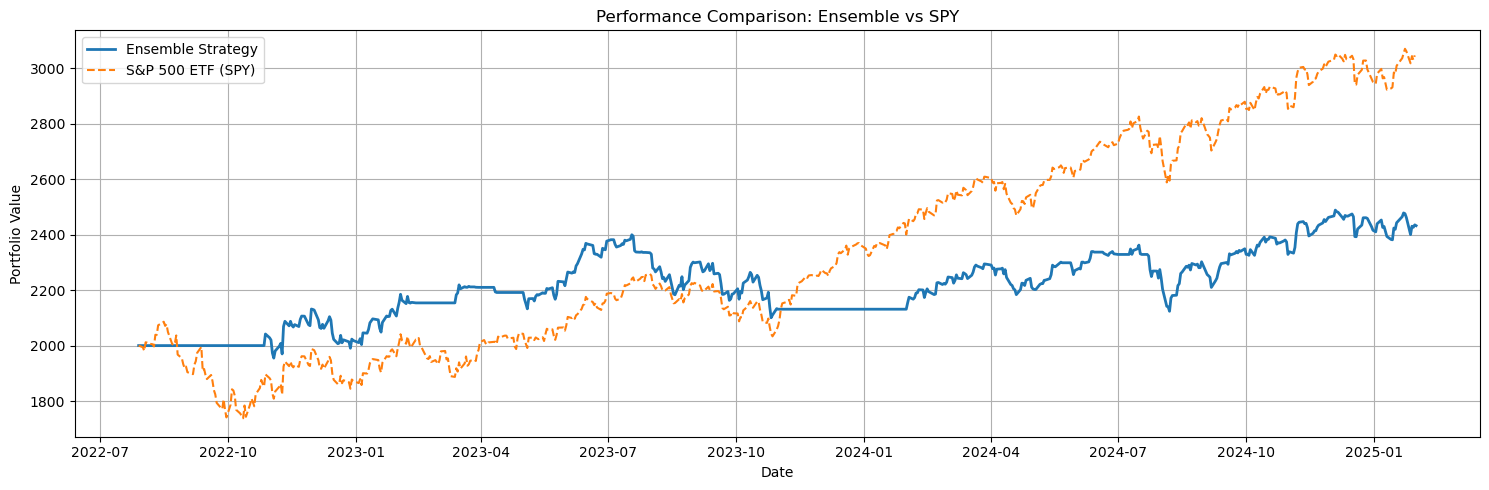

In [33]:
# === FINAL COMPARISON: ENSEMBLE VS SPY ===

import matplotlib.pyplot as plt

# Create result folder if not exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# Create result DataFrame from account value
df_result_ensemble = pd.DataFrame({
    "date": df_account_value["date"],
    "ensemble": df_account_value["account_value"]
})
df_result_ensemble.set_index("date", inplace=True)

# Save ensemble result
ensemble_path = os.path.join(RESULTS_DIR, "df_result_ensemble.csv")
df_result_ensemble.to_csv(ensemble_path)
print(f"Saved ensemble results to: {ensemble_path}")

# Download SPY baseline if not yet available
from finrl.plot import get_baseline

spy_baseline = get_baseline(
    ticker="SPY",
    start=df_account_value['date'].iloc[0],
    end=df_account_value['date'].iloc[-1]
)

# Normalize SPY value to start at same initial amount
df_spy = pd.DataFrame()
df_spy["date"] = df_account_value["date"]
df_spy["spy"] = spy_baseline["close"] / spy_baseline["close"].iloc[0] * env_kwargs["initial_amount"]
df_spy.set_index("date", inplace=True)

# Merge for comparison
result = pd.merge(df_result_ensemble, df_spy, left_index=True, right_index=True)
result.columns = ["ensemble", "spy"]

# Save final comparison CSV
comparison_path = os.path.join(RESULTS_DIR, "result_ensemble_vs_spy.csv")
result.to_csv(comparison_path)
print(f"Saved result comparison to: {comparison_path}")

# Plot comparison
plt.figure(figsize=(15, 5))
plt.plot(result.index, result["ensemble"], label="Ensemble Strategy", linewidth=2)
plt.plot(result.index, result["spy"], label="S&P 500 ETF (SPY)", linestyle="--")
plt.title("Performance Comparison: Ensemble vs SPY")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
